# Extract time series parameters from flow and use to predict extreme snowmelt

In [75]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, KFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_recall_curve, auc, classification_report, explained_variance_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt


In [2]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


In [3]:
# setup for search grid
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


In [4]:
# build scorer function
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


auc_pr = make_scorer(auc_pr_score, greater_is_better=True)

N_DAYS = 30

## Create rolled dataframe 

In [5]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
0,0,1945-05-23,0.00,0.00,0,51.0,157010.0,35296.197180,182.0000,1945,5,413.351800,1746.0,51.0 157010.0
1,1,1945-05-24,0.00,0.00,0,51.0,157010.0,35296.197180,176.0000,1945,5,413.351800,1746.0,51.0 157010.0
2,2,1945-05-25,0.00,0.00,0,51.0,157010.0,35296.197180,164.0000,1945,5,413.351800,1746.0,51.0 157010.0
3,3,1945-05-26,0.00,0.00,0,51.0,157010.0,35296.197180,152.0000,1945,5,413.351800,1746.0,51.0 157010.0
4,4,1945-05-27,0.00,0.00,0,51.0,157010.0,35296.197180,143.0000,1945,5,413.351800,1746.0,51.0 157010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506247,1556668,1995-10-16,0.00,0.00,0,17.0,172790.0,10680.378993,211.8655,1995,10,48.634316,381.0,17.0 172790.0
1506248,1556669,1995-10-17,0.00,0.00,0,17.0,172790.0,10680.378993,209.7427,1995,10,48.634316,381.0,17.0 172790.0
1506249,1556670,1995-10-18,0.00,0.00,0,17.0,172790.0,10680.378993,212.7924,1995,10,48.634316,381.0,17.0 172790.0
1506250,1556671,1995-10-19,0.04,0.04,0,17.0,172790.0,10680.378993,215.6614,1995,10,48.634316,381.0,17.0 172790.0


In [50]:
# remove site pairs with distance > 100 km and keep only nearest site pair
all_data_clean = all_data_clean[all_data_clean['distance'] < 10000]
idx = all_data_clean.groupby('flow_site_id')['distance'].transform(min) == all_data_clean['distance']
all_data_clean = all_data_clean[idx]
all_data_clean

,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id,unique_id
2205,2205,1952-11-11,0.18,0.09,0,1315.0,183760.0,325.142026,62.0000,1952,11,50.920328,218.0000,1315.0 183760.0,"(1315.0 183760.0, 1952-11-11)"
2209,2209,1956-10-21,0.00,0.00,0,1315.0,183760.0,325.142026,72.0000,1956,10,60.541542,252.4545,1315.0 183760.0,"(1315.0 183760.0, 1956-10-21)"
2213,2213,1957-04-30,0.00,-0.11,1,1315.0,183760.0,325.142026,24.0000,1957,4,27.770907,177.0000,1315.0 183760.0,"(1315.0 183760.0, 1957-04-30)"
2218,2218,1957-10-03,0.00,0.00,0,1315.0,183760.0,325.142026,189.0000,1957,10,91.637784,391.8382,1315.0 183760.0,"(1315.0 183760.0, 1957-10-03)"
2222,2222,1957-10-04,0.12,0.12,0,1315.0,183760.0,325.142026,187.0000,1957,10,91.637784,391.8382,1315.0 183760.0,"(1315.0 183760.0, 1957-10-04)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498865,1549286,2020-10-05,0.00,0.00,0,2053.0,126430.0,4452.589044,0.0645,2020,10,68.098947,736.0000,2053.0 126430.0,"(2053.0 126430.0, 2020-10-05)"
1498866,1549287,2020-10-15,0.00,0.00,0,2053.0,126430.0,4452.589044,0.4668,2020,10,68.098947,736.0000,2053.0 126430.0,"(2053.0 126430.0, 2020-10-15)"
1498867,1549288,2020-10-19,0.00,0.00,0,2053.0,126430.0,4452.589044,0.2470,2020,10,68.098947,736.0000,2053.0 126430.0,"(2053.0 126430.0, 2020-10-19)"
1498868,1549289,2020-11-01,0.00,0.00,0,2053.0,126430.0,4452.589044,0.4525,2020,11,80.551386,1014.0000,2053.0 126430.0,"(2053.0 126430.0, 2020-11-01)"


In [64]:
# remove data before 1960
all_data_clean = all_data_clean[all_data_clean['year'] > 1960]
all_data_clean


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
4714,4714,1961-01-03,0.47,0.03,0,1315.0,183760.0,325.142026,23.0000,1961,1,28.655440,105.00,1315.0 183760.0
4720,4720,1961-01-04,0.48,0.04,0,1315.0,183760.0,325.142026,23.0000,1961,1,28.655440,105.00,1315.0 183760.0
4726,4726,1961-01-05,0.49,0.02,0,1315.0,183760.0,325.142026,23.0000,1961,1,28.655440,105.00,1315.0 183760.0
4732,4732,1961-01-06,0.51,0.03,0,1315.0,183760.0,325.142026,23.0000,1961,1,28.655440,105.00,1315.0 183760.0
4738,4738,1961-01-07,0.51,0.02,0,1315.0,183760.0,325.142026,23.0000,1961,1,28.655440,105.00,1315.0 183760.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498865,1549286,2020-10-05,0.00,0.00,0,2053.0,126430.0,4452.589044,0.0645,2020,10,68.098947,736.00,2053.0 126430.0
1498866,1549287,2020-10-15,0.00,0.00,0,2053.0,126430.0,4452.589044,0.4668,2020,10,68.098947,736.00,2053.0 126430.0
1498867,1549288,2020-10-19,0.00,0.00,0,2053.0,126430.0,4452.589044,0.2470,2020,10,68.098947,736.00,2053.0 126430.0
1498868,1549289,2020-11-01,0.00,0.00,0,2053.0,126430.0,4452.589044,0.4525,2020,11,80.551386,1014.00,2053.0 126430.0


In [15]:

df_rolled = roll_time_series(
    all_data_clean[['date', 'site_id', 'flow', 'binary']], column_id="site_id", column_sort="date", max_timeshift=N_DAYS, min_timeshift=N_DAYS - 1, n_jobs=20)


Rolling: 100%|██████████| 100/100 [03:35<00:00,  2.16s/it]


In [16]:
df_rolled

,date,site_id,flow,binary,id
2128987,1972-01-01,10006.0 192830.0,16.0,1,"(10006.0 192830.0, 1972-01-30)"
2128988,1972-01-02,10006.0 192830.0,16.0,1,"(10006.0 192830.0, 1972-01-30)"
2128989,1972-01-03,10006.0 192830.0,16.0,0,"(10006.0 192830.0, 1972-01-30)"
2128990,1972-01-04,10006.0 192830.0,16.0,0,"(10006.0 192830.0, 1972-01-30)"
2128991,1972-01-05,10006.0 192830.0,16.0,0,"(10006.0 192830.0, 1972-01-30)"
...,...,...,...,...,...
2734179,1984-12-27,655.0 113190.0,9.8,0,"(655.0 113190.0, 1984-12-31)"
2734180,1984-12-28,655.0 113190.0,9.6,0,"(655.0 113190.0, 1984-12-31)"
2734181,1984-12-29,655.0 113190.0,9.4,0,"(655.0 113190.0, 1984-12-31)"
2734182,1984-12-30,655.0 113190.0,9.2,0,"(655.0 113190.0, 1984-12-31)"


In [17]:
df_rolled.to_csv('../df_rolled_' + str(N_DAYS) + '_dist_unique.csv', index=False)

## Extract minimal timeseries features

In [18]:
df_rolled = pd.read_csv('../df_rolled_' + str(N_DAYS) + '_dist_unique.csv')


In [19]:
df_rolled

,date,site_id,flow,binary,id
0,1972-01-01,10006.0 192830.0,16.0,1,"('10006.0 192830.0', '1972-01-30')"
1,1972-01-02,10006.0 192830.0,16.0,1,"('10006.0 192830.0', '1972-01-30')"
2,1972-01-03,10006.0 192830.0,16.0,0,"('10006.0 192830.0', '1972-01-30')"
3,1972-01-04,10006.0 192830.0,16.0,0,"('10006.0 192830.0', '1972-01-30')"
4,1972-01-05,10006.0 192830.0,16.0,0,"('10006.0 192830.0', '1972-01-30')"
...,...,...,...,...,...
9751308,1984-12-27,655.0 113190.0,9.8,0,"('655.0 113190.0', '1984-12-31')"
9751309,1984-12-28,655.0 113190.0,9.6,0,"('655.0 113190.0', '1984-12-31')"
9751310,1984-12-29,655.0 113190.0,9.4,0,"('655.0 113190.0', '1984-12-31')"
9751311,1984-12-30,655.0 113190.0,9.2,0,"('655.0 113190.0', '1984-12-31')"


In [20]:
# extract timeseries features

X_features_all = extract_features(
	df_rolled.drop(["binary"], axis=1), column_id='id', column_sort='date', column_value="flow", 
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


X_features_all.head()


Feature Extraction: 100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
"('10006.0 192830.0', '1972-01-30')",434.0,14.0,14.466667,30.0,0.921352,0.848889,14.495976,16.0,13.0
"('10006.0 192830.0', '1972-01-31')",447.0,14.0,14.419355,31.0,0.942686,0.888658,14.450137,16.0,13.0
"('10006.0 192830.0', '1972-02-01')",444.0,14.0,14.322581,31.0,0.929346,0.863684,14.352700,16.0,13.0
"('10006.0 192830.0', '1972-02-02')",441.0,14.0,14.225806,31.0,0.905527,0.819979,14.254597,16.0,13.0
"('10006.0 192830.0', '1972-02-03')",438.0,14.0,14.129032,31.0,0.870370,0.757544,14.155815,16.0,13.0


In [21]:
X_features_all.to_csv('../df_extracted_min_' + str(N_DAYS) + '_dist_unique.csv')


## Undersample minimal timeseries feature dataset and run Random Forest model

In [22]:
X_features_all = pd.read_csv(
    '../df_extracted_min_' + str(N_DAYS) + '_dist_unique.csv')


In [23]:
import ast

X_features_all['unique_id'] = X_features_all['Unnamed: 0'].apply(ast.literal_eval)
X_features_all = X_features_all.drop('Unnamed: 0', axis=1)
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id
0,434.0,14.0,14.466667,30.0,0.921352,0.848889,14.495976,16.0,13.0,"(10006.0 192830.0, 1972-01-30)"
1,447.0,14.0,14.419355,31.0,0.942686,0.888658,14.450137,16.0,13.0,"(10006.0 192830.0, 1972-01-31)"
2,444.0,14.0,14.322581,31.0,0.929346,0.863684,14.352700,16.0,13.0,"(10006.0 192830.0, 1972-02-01)"
3,441.0,14.0,14.225806,31.0,0.905527,0.819979,14.254597,16.0,13.0,"(10006.0 192830.0, 1972-02-02)"
4,438.0,14.0,14.129032,31.0,0.870370,0.757544,14.155815,16.0,13.0,"(10006.0 192830.0, 1972-02-03)"


In [24]:
all_data_clean = pd.read_csv('../all_data_clean.csv')
all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.date))


In [25]:
X_features_all = pd.merge(X_features_all, all_data_clean[['binary', 'unique_id']], how='left', on='unique_id')
X_features_all = X_features_all.set_index(
    X_features_all['unique_id'], drop=True)
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id,binary
unique_id,,,,,,,,,,,
"(10006.0 192830.0, 1972-01-30)",434.0,14.0,14.466667,30.0,0.921352,0.848889,14.495976,16.0,13.0,"(10006.0 192830.0, 1972-01-30)",0
"(10006.0 192830.0, 1972-01-31)",447.0,14.0,14.419355,31.0,0.942686,0.888658,14.450137,16.0,13.0,"(10006.0 192830.0, 1972-01-31)",0
"(10006.0 192830.0, 1972-02-01)",444.0,14.0,14.322581,31.0,0.929346,0.863684,14.352700,16.0,13.0,"(10006.0 192830.0, 1972-02-01)",0
"(10006.0 192830.0, 1972-02-02)",441.0,14.0,14.225806,31.0,0.905527,0.819979,14.254597,16.0,13.0,"(10006.0 192830.0, 1972-02-02)",0
"(10006.0 192830.0, 1972-02-03)",438.0,14.0,14.129032,31.0,0.870370,0.757544,14.155815,16.0,13.0,"(10006.0 192830.0, 1972-02-03)",0


In [26]:
y1 = X_features_all['binary']
Counter(y1)


Counter({0: 297245, 1: 17315})

In [27]:
# undersample to balance classes
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

# undersample = RandomUnderSampler(sampling_strategy='majority')
# undersample = RandomUnderSampler(sampling_strategy=0.5)
undersample = NearMiss(version=3, n_neighbors=3)
# undersample = OneSidedSelection(n_jobs=20)
X_under, y_under = undersample.fit_resample(
    X_features_all.drop(columns=['binary', 'unique_id']), y1)


In [28]:
X_under.index = X_features_all.index[undersample.sample_indices_]
Counter(y_under)


Counter({0: 17315, 1: 17315})

In [29]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_under, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.73      0.87      0.79      6965
           1       0.84      0.68      0.75      6887

    accuracy                           0.77     13852
   macro avg       0.78      0.77      0.77     13852
weighted avg       0.78      0.77      0.77     13852



In [30]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


0.8368936764100101

In [31]:
df_rolled['unique_id'] = df_rolled['id'].apply(ast.literal_eval)
df_rolled.unique_id

0          (10006.0 192830.0, 1972-01-30)
1          (10006.0 192830.0, 1972-01-30)
2          (10006.0 192830.0, 1972-01-30)
3          (10006.0 192830.0, 1972-01-30)
4          (10006.0 192830.0, 1972-01-30)
                        ...              
9751308      (655.0 113190.0, 1984-12-31)
9751309      (655.0 113190.0, 1984-12-31)
9751310      (655.0 113190.0, 1984-12-31)
9751311      (655.0 113190.0, 1984-12-31)
9751312      (655.0 113190.0, 1984-12-31)
Name: unique_id, Length: 9751313, dtype: object

In [32]:
X_under.head()

,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
unique_id,,,,,,,,,
"(1147.0 192830.0, 1936-05-26)",9131.0000,127.0000,294.548387,31.0,317.580555,100857.408949,433.146813,1001.0000,11.00
"(10006.0 192830.0, 2000-06-07)",8924.0000,74.0000,287.870968,31.0,317.448573,100773.596254,428.536218,898.0000,24.00
"(1147.0 192830.0, 1936-05-25)",8537.0000,60.0000,275.387097,31.0,316.248440,100013.075963,419.346073,1001.0000,10.00
"(2012.0 183760.0, 1973-11-07)",5019.5364,42.4645,161.920529,31.0,247.683384,61347.058950,295.914374,772.6235,34.94
"(1315.0 183760.0, 1959-11-29)",5481.0000,76.0000,176.806452,31.0,247.984836,61496.478668,304.560339,1009.0000,48.00


In [33]:
X_under_all = df_rolled[df_rolled.unique_id.isin(X_under.index)]
X_under_all


,date,site_id,flow,binary,id,unique_id
588,1972-01-19,10006.0 192830.0,14.0,0,"('10006.0 192830.0', '1972-02-18')","(10006.0 192830.0, 1972-02-18)"
589,1972-01-20,10006.0 192830.0,14.0,0,"('10006.0 192830.0', '1972-02-18')","(10006.0 192830.0, 1972-02-18)"
590,1972-01-21,10006.0 192830.0,14.0,0,"('10006.0 192830.0', '1972-02-18')","(10006.0 192830.0, 1972-02-18)"
591,1972-01-22,10006.0 192830.0,14.0,0,"('10006.0 192830.0', '1972-02-18')","(10006.0 192830.0, 1972-02-18)"
592,1972-01-23,10006.0 192830.0,14.0,0,"('10006.0 192830.0', '1972-02-18')","(10006.0 192830.0, 1972-02-18)"
...,...,...,...,...,...,...
9750626,1984-04-26,655.0 113190.0,51.0,1,"('655.0 113190.0', '1984-12-05')","(655.0 113190.0, 1984-12-05)"
9750627,1984-04-27,655.0 113190.0,54.0,0,"('655.0 113190.0', '1984-12-05')","(655.0 113190.0, 1984-12-05)"
9750628,1984-12-03,655.0 113190.0,21.0,0,"('655.0 113190.0', '1984-12-05')","(655.0 113190.0, 1984-12-05)"
9750629,1984-12-04,655.0 113190.0,19.4,0,"('655.0 113190.0', '1984-12-05')","(655.0 113190.0, 1984-12-05)"


In [34]:
X_under_all.to_csv('../df_undersampled_nearmiss_' +
                   str(N_DAYS) + '_dist_unique.csv', index=False)


## Extract complete set of timeseries features on undersampled dataframe

In [35]:
X_under_all = pd.read_csv(
    '../df_undersampled_nearmiss_' + str(N_DAYS) + '_dist_unique.csv')


In [36]:
# Split dataframe in two to avoid problems with memory

X_under_all.sort_values(by=['unique_id'])

X_under_1 = X_under_all[:len(X_under_all)//2]
X_under_2 = X_under_all[len(X_under_all)//2:]


In [37]:
X_features_under_1 = extract_features(
	X_under_1.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


In [38]:
X_features_under_1.to_csv(
    '../df_extracted_1_nearmiss_' + str(N_DAYS) + '_dist_unique.csv')


In [39]:
X_features_under_2 = extract_features(
	X_under_2.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [02:09<00:00,  2.58s/it]


In [40]:
X_features_under_2.to_csv(
    '../df_extracted_2_nearmiss_' + str(N_DAYS) + '_dist_unique.csv')


In [41]:
X_features_under_1 = pd.read_csv(
    '../df_extracted_1_nearmiss_' + str(N_DAYS) + '_dist_unique.csv')
X_features_under_2 = pd.read_csv(
    '../df_extracted_2_nearmiss_' + str(N_DAYS) + '_dist_unique.csv')

X_features_under_all = pd.concat([X_features_under_1, X_features_under_2])
X_features_under_all.shape


(34631, 788)

In [42]:
X_features_under_all.to_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '_dist_unique.csv', index=False)


## Build Random Forest model with complete set of extracted timeseries parameters

In [43]:
import ast

X_features_under_all = pd.read_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '_dist_unique.csv')

all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.date))

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'binary', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)
y_under = X_features_under_all['binary']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'binary'])
X_features_under_filtered.head()


,flow__variance_larger_than_standard_deviation,flow__has_duplicate_max,flow__has_duplicate_min,flow__has_duplicate,flow__sum_values,flow__abs_energy,flow__median,flow__mean,flow__length,flow__standard_deviation,...,flow__ratio_beyond_r_sigma__r_6,flow__ratio_beyond_r_sigma__r_7,flow__ratio_beyond_r_sigma__r_10,flow__count_above__t_0,flow__count_below__t_0,flow__lempel_ziv_complexity__bins_2,flow__lempel_ziv_complexity__bins_3,flow__lempel_ziv_complexity__bins_5,flow__lempel_ziv_complexity__bins_10,flow__lempel_ziv_complexity__bins_100
unique_id,,,,,,,,,,,,,,,,,,,,,
"(10006.0 192830.0, 1972-02-18)",0.0,1.0,0.0,1.0,397.0,5107.0,13.0,12.806452,31.0,0.858331,...,0.0,0.0,0.0,1.0,0.0,0.258065,0.354839,0.419355,0.419355,0.419355
"(10006.0 192830.0, 1972-05-02)",0.0,1.0,1.0,1.0,335.0,3629.0,11.0,10.806452,31.0,0.533966,...,0.0,0.0,0.0,1.0,0.0,0.322581,0.354839,0.354839,0.354839,0.354839
"(10006.0 192830.0, 1972-05-03)",0.0,0.0,1.0,1.0,339.0,3725.0,11.0,10.935484,31.0,0.759265,...,0.0,0.0,0.0,1.0,0.0,0.322581,0.354839,0.387097,0.387097,0.387097
"(10006.0 192830.0, 1972-05-10)",1.0,1.0,1.0,1.0,430.0,6758.0,11.0,13.870968,31.0,5.059274,...,0.0,0.0,0.0,1.0,0.0,0.322581,0.354839,0.387097,0.387097,0.387097
"(10006.0 192830.0, 1972-05-11)",1.0,0.0,1.0,1.0,444.0,7262.0,11.0,14.322581,31.0,5.396457,...,0.0,0.0,0.0,1.0,0.0,0.322581,0.387097,0.387097,0.419355,0.419355


In [44]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      7042
           1       0.89      0.80      0.84      6811

    accuracy                           0.85     13853
   macro avg       0.86      0.85      0.85     13853
weighted avg       0.86      0.85      0.85     13853



0.8934346090791092

In [74]:
# split into train and test sets by date
X_filtered_sorted = X_features_under_filtered.sort_index(key=lambda d: d.map(lambda x: x[1]))
X_filtered_train = X_filtered_sorted.iloc[:len(X_filtered_sorted)//10*6]
X_filtered_test = X_filtered_sorted.iloc[len(X_filtered_sorted)//10*6:]
y_train = y_under.iloc[:len(X_filtered_sorted)//10*6]
y_test = y_under.iloc[len(X_filtered_sorted)//10*6:]

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.56      0.34      0.43      7778
           1       0.44      0.65      0.52      6075

    accuracy                           0.48     13853
   macro avg       0.50      0.50      0.47     13853
weighted avg       0.50      0.48      0.47     13853



0.6197719070554865

In [84]:
# split into training and test sets by site
indx = X_features_under_filtered.index.unique()
sites = [x[0] for x in indx]
sites = list(set(sites))
sites_test = sites[:len(sites)//10*6]
sites_train = sites[len(sites)//10*6:]
idx_train = [x for x in indx if x[0] in sites_train]
idx_test = [x for x in indx if x[0] in sites_test]
X_filtered_train = X_features_under_filtered[X_features_under_filtered.index.isin(idx_train)]
X_filtered_test = X_features_under_filtered[X_features_under_filtered.index.isin(idx_test)]
y_train = y_under[y_under.index.isin(idx_train)]
y_test = y_under[y_under.index.isin(idx_test)]

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.74      0.91      0.81      9287
           1       0.89      0.70      0.79     10185

    accuracy                           0.80     19472
   macro avg       0.81      0.80      0.80     19472
weighted avg       0.82      0.80      0.80     19472



0.8748916782534244

In [71]:
len(sites)

47

In [91]:
# time series split
tscv = TimeSeriesSplit(n_splits=10)

index_output = tscv.split(X_filtered_sorted)

clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1, max_depth=1)
cv_results = cross_validate(
    clf,
    X_filtered_sorted,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


0.6462553700129522


In [39]:
# try automatic feature selection

sel = SelectFromModel(RandomForestClassifier(n_jobs=-1, random_state=42))
sel.fit(X_filtered_train, y_train)
selected_feat = X_filtered_train.columns[(sel.get_support())]

In [46]:
X_selected = X_features_under_filtered[selected_feat]
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_selected, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.82      0.89      0.85      7113
           1       0.88      0.80      0.84      7071

    accuracy                           0.85     14184
   macro avg       0.85      0.85      0.85     14184
weighted avg       0.85      0.85      0.85     14184



0.8897819954399702

<AxesSubplot:>

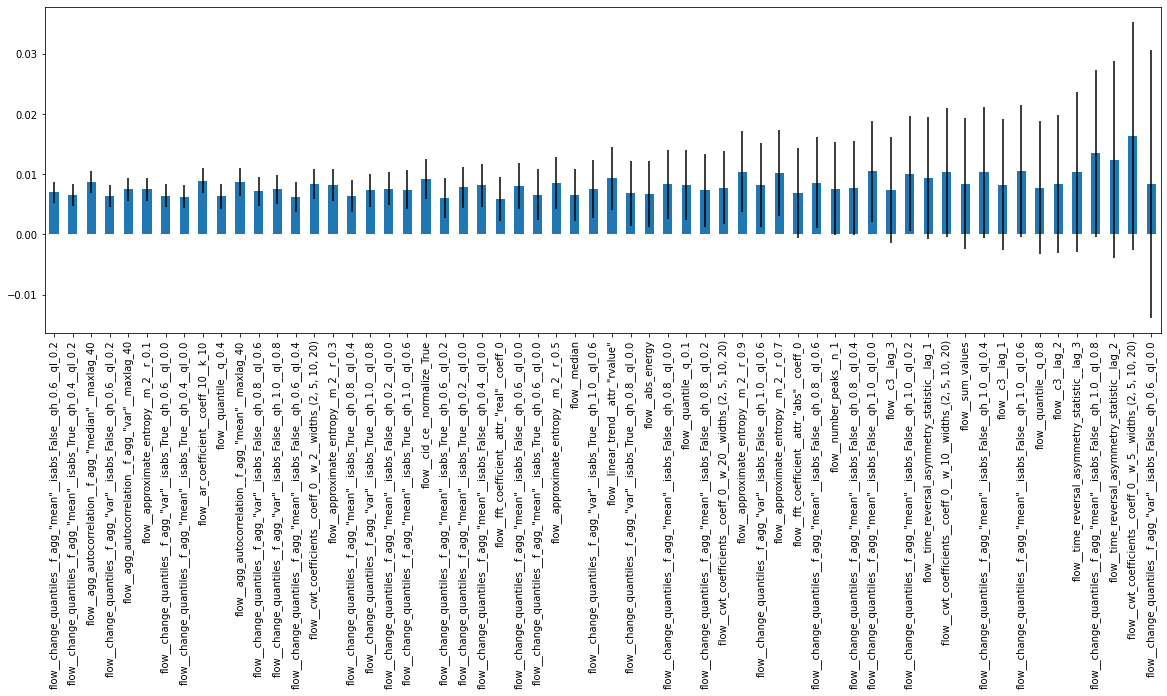

In [41]:
# features with lowest standard deviation

importances = classifier_filtered.feature_importances_
forest_importances = pd.Series(importances, index=X_selected.columns)

std = np.std(
    [tree.feature_importances_ for tree in classifier_filtered.estimators_], axis=0)
lowest_std_indices = pd.Series(
    std, index=X_selected.columns).nsmallest(60).index
lowest_std = pd.Series(
    std, index=X_selected.columns).nsmallest(60)

lowest_features = forest_importances[lowest_std_indices]

plt.figure(figsize=(20, 6))
lowest_features.plot.bar(yerr=lowest_std)


<AxesSubplot:>

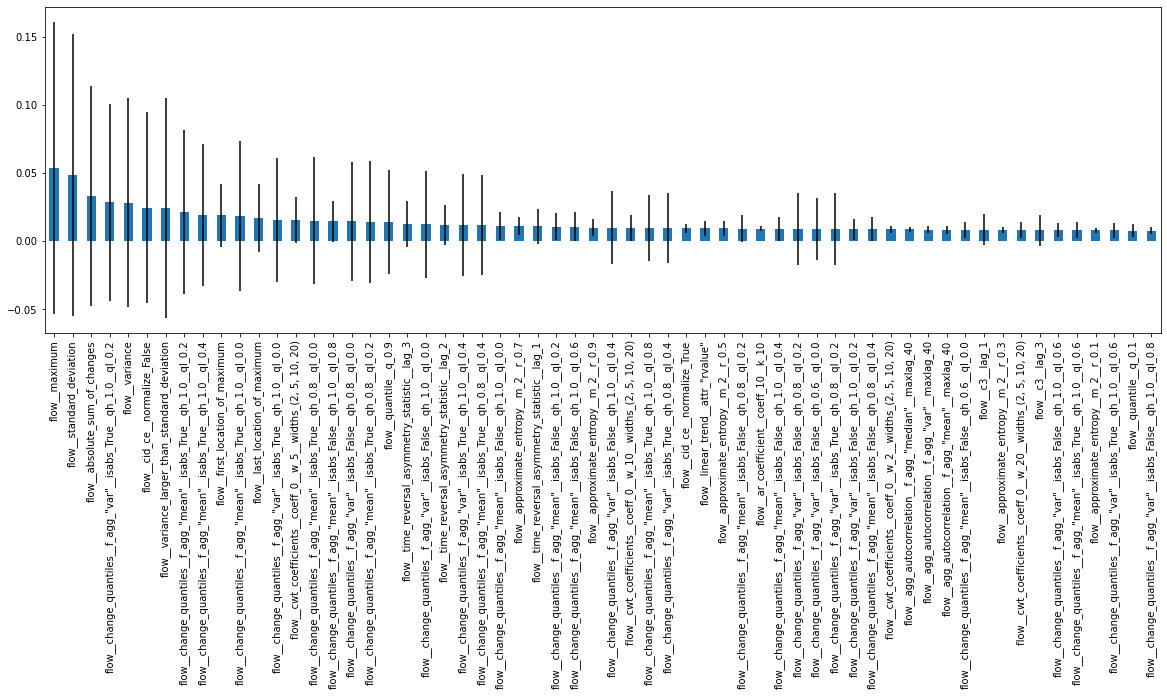

In [47]:
# features with highest importance
importances = classifier_filtered.feature_importances_
forest_importances = pd.Series(importances, index=X_selected.columns)
main_features = forest_importances.nlargest(60)
main_features_indices = pd.Series(importances).nlargest(60).index

std = np.std(
    [tree.feature_importances_ for tree in classifier_filtered.estimators_], axis=0)
main_std = std[main_features_indices]

plt.figure(figsize=(20, 6))
main_features.plot.bar(yerr=main_std)


## Select relevant features and run model only on those

In [92]:
# select relevant features
X_filtered = select_features(X_features_under_filtered, y_under, n_jobs=20)

X_filtered.head()


,flow__sum_values,"flow__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",...,"flow__agg_autocorrelation__f_agg_""median""__maxlag_40",flow__ratio_beyond_r_sigma__r_3,flow__number_crossing_m__m_0,flow__ratio_beyond_r_sigma__r_2.5,flow__ratio_beyond_r_sigma__r_5,flow__ratio_beyond_r_sigma__r_0.5,flow__symmetry_looking__r_0.15000000000000002,flow__symmetry_looking__r_0.1,flow__last_location_of_minimum,flow__approximate_entropy__m_2__r_0.3
unique_id,,,,,,,,,,,,,,,,,,,,,
"(10006.0 192830.0, 1972-02-18)",397.0,0.064209,0.064209,0.068966,0.064209,0.045351,0.047619,0.045351,-0.047619,0.000000,...,-0.534507,0.000000,0.0,0.000000,0.0,0.677419,1.0,1.0,1.000000,0.220197
"(10006.0 192830.0, 1972-05-02)",335.0,0.128889,0.035665,0.037037,0.035665,0.035665,0.037037,0.035665,0.037037,0.035665,...,-0.307555,0.000000,0.0,0.000000,0.0,0.322581,1.0,1.0,0.258065,0.251804
"(10006.0 192830.0, 1972-05-03)",339.0,0.248889,0.036982,0.038462,0.036982,0.036982,0.038462,0.036982,0.038462,0.036982,...,-0.024828,0.032258,0.0,0.032258,0.0,0.322581,1.0,1.0,0.225806,0.249330
"(10006.0 192830.0, 1972-05-10)",430.0,1.445556,0.817708,0.375000,0.873264,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.291109,0.000000,0.0,0.000000,0.0,0.903226,0.0,0.0,0.709677,0.105235
"(10006.0 192830.0, 1972-05-11)",444.0,1.448889,1.659722,0.583333,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.352115,0.000000,0.0,0.000000,0.0,0.903226,0.0,0.0,0.677419,0.112104


In [93]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86      7029
           1       0.89      0.80      0.84      6824

    accuracy                           0.85     13853
   macro avg       0.86      0.85      0.85     13853
weighted avg       0.86      0.85      0.85     13853



0.8960711175942538

In [94]:
# time series split
tscv = TimeSeriesSplit(n_splits=10)
X_filtered_sorted = X_filtered.sort_index(key=lambda d: d.map(lambda x: x[1]))
index_output = tscv.split(X_filtered_sorted)

clf = RandomForestClassifier(
    random_state=42, verbose=0, n_jobs=-1, max_depth=1)
cv_results = cross_validate(
    clf,
    X_filtered_sorted,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


0.6874447647204438


In [48]:
# try with grid search


kf = KFold()
index_output = kf.split(X_features_under_filtered)

clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)

param_distributions = {
	'n_estimators': loguniform_int(2, 256),
	'criterion': ['gini', 'entropy'],
	'min_samples_split': loguniform_int(2, 256),
	'min_samples_leaf': loguniform_int(1, 100),
	'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}, {0: 1, 1: 1}],
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X_features_under_filtered, y_under)
n_estimators = model_random_search.best_params_['n_estimators']
criterion = model_random_search.best_params_['criterion']
min_samples_split = model_random_search.best_params_['min_samples_split']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
class_weight = model_random_search.best_params_['class_weight']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
# random forest - cross validation with new parameters

new_regressor = RandomForestClassifier(
    random_state=42,
   	n_jobs=-1, verbose=0,
   	criterion=criterion,
   	min_samples_leaf=min_samples_leaf,
   	min_samples_split=min_samples_split,
   	n_estimators=n_estimators
)
index_output = kf.split(X_filtered)

cv_results = cross_validate(
    new_regressor,
    X_filtered,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


## Predict snow diff using complete timeseries parameters

In [ ]:
import ast
X_features_under_all = pd.read_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '.csv')
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.date))

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'depth_diff', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)

y_under = X_features_under_all['depth_diff']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'depth_diff'])
X_features_under_filtered.head()




In [ ]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)


In [ ]:
y_pred = classifier_filtered.predict(X_filtered_test)
print('Explained variance score: {0}, MSE: {1}, R2: {2}'.format(explained_variance_score(y_test, y_pred),
                                                                mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))


## Exploration of most meaningful parameters

In [28]:

scaler = StandardScaler().fit_transform(X_selected)
data_standardized = pd.DataFrame(
    scaler, columns=X_selected.columns)
pca = PCA(random_state=42, n_components=5)
pca.fit(data_standardized)
print(pca.explained_variance_ratio_)


[0.323825   0.11732946 0.08438674 0.05942375 0.04554057]


Text(0, 0.5, '2nd PC')

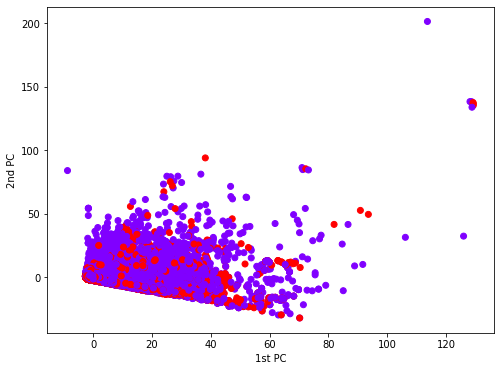

In [29]:
x_pca = pca.transform(data_standardized)

plt.figure(figsize=(8, 6))
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1],
            c=y_under, cmap='rainbow')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
